In [342]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
from sklearn.preprocessing import LabelBinarizer
import funcs_my_and_from_git

С сайта Bikez.com был собран с помощью специального парсера с целью пополнить существующий набор данных по бывшим в употреблении мотоциклам. Там хранится информация о характеристиках проданных мотоциклах до 2022 года.

all_bikez_curated.csv — это то, что осталось от необработанного набора данных после прохождения начальной стадии предварительной обработки, на которой сохранялись только наиболее доступные и наиболее релевантные атрибуты.

Используя этот набор данных, мы могли бы попытаться создать модель, работа которой отражала бы суть того, что исторически предполагалось в каждой категории мотоциклов. Итак, попробуем изучить возможность определить, к какому типу относится мотоцикл в соответствии с его **техническими характеристиками**.

Описание характеристик:

* `Brand` - марка мотоцикла
* `Model` - модель мотоцикла
* `Year` - год производства мотоцикла
* `Category` – класс, к которому принадлежит мотоцикл на рынке
* `Rating` - средний рейтинг из 5 звезд
* `Displacement (ccm)` — объем двигателя мотоцикла в кубических сантиметрах (см3)
* `Power (hp)` — максимальная выходная мощность в лошадиных силах (л.с.)
* `Torque (Nm)` — максимальный крутящий момент в ньютон-метрах (Нм)
* `Engine cylinder` — количество цилиндров в двигателе, а также конфигурация
* `Engine stroke` - количество тактов для завершения одного рабочего хода двигателя
* `Gearbox` – количество передач
* `Bore (mm)` — диаметр цилиндров в миллиметрах (мм)
* `Stroke (mm)` — расстояние внутри цилиндра, которое проходит поршень в миллиметрах(мм)
* `Transmission type` - тип трансмиссии мотоцикла
* `Front brakes` - тип переднего тормоза
* `Rear brakes` - тип заднего тормоза
* `Front tire` - размер передней шины
* `Rear tire` - размер задней шины
* `Front suspension` - тип и конфигурация передней подвески
* `Rear suspension` - тип и конфигурация задней подвески
* `Dry weight (kg)` - вес мотоцикла без каких-либо жидкостей, в килограммах (кг)
* `Wheelbase (mm)` - расстояние между точками соприкосновения передних и задних колес с землей в миллиметрах (мм)
* `Fuel capacity (lts)` - максимальная вместимость топливного бака в литрах (лт)
* `Fuel system` - система подачи топлива в двигатель
* `Fuel control` – конфигурация клапанов двигателя
* `Seat height (mm)` - высота от низа сиденья до земли в миллиметрах (мм)
* `Cooling system` – система охлаждения двигателя
* `Color options` — возможные варианты цвета модели мотоцикла для конкретного года выпуска

In [343]:
data_raw = pd.read_csv("all_bikez_curated.csv")
print(f'''
Число объектов: {data_raw.shape[0]}
Число признаков: {data_raw.shape[1]}''')


Число объектов: 38472
Число признаков: 28


In [344]:
data_raw.head(3)

,Brand,Model,Year,Category,Rating,Displacement (ccm),Power (hp),Torque (Nm),Engine cylinder,Engine stroke,...,Dry weight (kg),Wheelbase (mm),Seat height (mm),Front brakes,Rear brakes,Front tire,Rear tire,Front suspension,Rear suspension,Color options
0,acabion,da vinci 650-vi,2011,Prototype / concept model,3.2,NaN,804.0,NaN,Electric,Electric,...,420.0,NaN,NaN,Single disc,Single disc,NaN,NaN,NaN,NaN,NaN
1,acabion,gtbo 55,2007,Sport,2.6,1300.0,541.0,420.0,In-line four,four-stroke,...,360.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,acabion,gtbo 600 daytona-vi,2011,Prototype / concept model,3.5,NaN,536.0,NaN,Electric,Electric,...,420.0,NaN,NaN,Single disc,Single disc,NaN,NaN,NaN,NaN,NaN


Сразу избавимся от невлияющих на исход признаков, таких как 'Brand', 'Model' и 'Rating'. Они не описывают характеристики мотоцикла. А ведь цель определить тип мотоцикла по его техническим характеристикам.

In [345]:
irrelevant_columns = ['Brand', 'Model', 'Rating']
data_raw = data_raw.drop(columns=irrelevant_columns)

Отрисуем график типов мотоциклов, представленных в данном датасете.

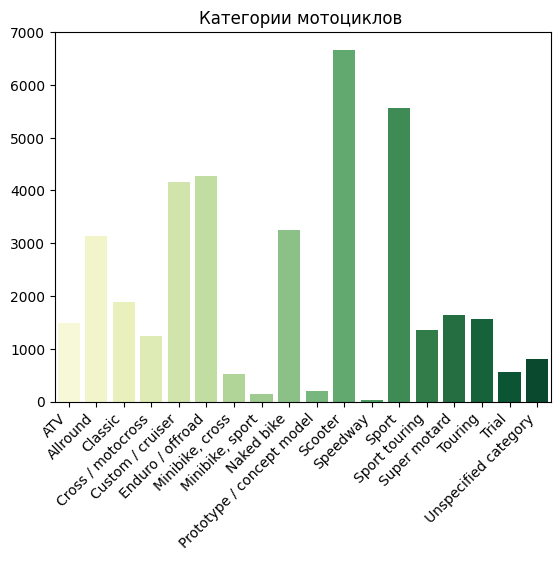

In [346]:
showSchedule(data_raw)
pass

На графике можно увидеть столбец "Unspecified category", он не представляет для нас никакой ценности, а наоборот лишь мешает, поэтому нужно удалить его из датафрейма.

In [347]:
unsp_index = data_raw['Category'] == 'Unspecified category'
data_raw = data_raw[~unsp_index]

Следом мы можем заметить несколько малочисленных представителей классов мотоциклов. Их число не переваливает за 150, и, казалось бы, от них можно избавиться, но сначала попробуем почистить "бракованные" строки таблицы.

Так получилось, что в данном датасете много пропущенных полей, а значения столбцов могут колебаться до 6000. В общем, любые приемы по работе с NaN полями приведут только к ухудшению обучения модели. Попробуем удалить все строки, в которых есть хоть одно пропущенное значение и посмотрим сколько же останется от каждого представителя Category.

In [348]:
conditions = [~data_raw[col].isnull() for col in data_raw.columns]
cond = conditions[0]
for c in conditions[1:]:
    cond = cond & c
selected_rows = cond[cond==True]
data_raw = data_raw.loc[selected_rows.index,:]

In [349]:
data_raw.isnull().sum()

Year                   0
Category               0
Displacement (ccm)     0
Power (hp)             0
Torque (Nm)            0
Engine cylinder        0
Engine stroke          0
Gearbox                0
Bore (mm)              0
Stroke (mm)            0
Fuel capacity (lts)    0
Fuel system            0
Fuel control           0
Cooling system         0
Transmission type      0
Dry weight (kg)        0
Wheelbase (mm)         0
Seat height (mm)       0
Front brakes           0
Rear brakes            0
Front tire             0
Rear tire              0
Front suspension       0
Rear suspension        0
Color options          0
dtype: int64

Снова построим график, можем видеть, что численность представителей каждого из классов уменьшилась пропорционально.

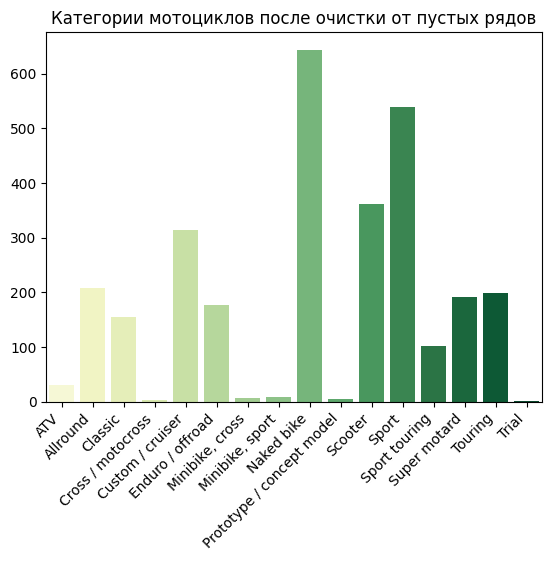

In [350]:
showSchedule(data_raw, 'Category', "после очистки от пустых рядов")
pass

Выбросим все строки, категория которых представлена в количестве меньше 100:

In [351]:
count_threshold = 100
counted = data_raw.groupby('Category').count()
cat_to_drop = counted[counted.max(axis=1) < count_threshold].index.tolist()
index_to_drop = []
for cat in cat_to_drop:
    index_to_drop += data_raw[data_raw['Category'] == cat].index.tolist()
data_raw = data_raw.drop(index=index_to_drop)

Набор данных должен быть сбалансированным. Перепредставленные категории подвергаются случайному уменьшению выборки. Выбранный критерий заключается в том, что ни в одной категории не будет более чем в два раза больше примеров, чем в наименее часто встречающейся категории.

In [352]:
lowest_count = data_raw.groupby('Category').count().max(axis=1).min()
n_random_rows = lowest_count * 2
row_blocks = []
for cat in data_raw.groupby('Category').count().index:
    row_blocks.append(randomRaws(data_raw[data_raw['Category']==cat], n_random_rows))
data_raw = pd.concat(row_blocks)
data_raw.sort_index(inplace=True)

Еще раз взглянем на график.

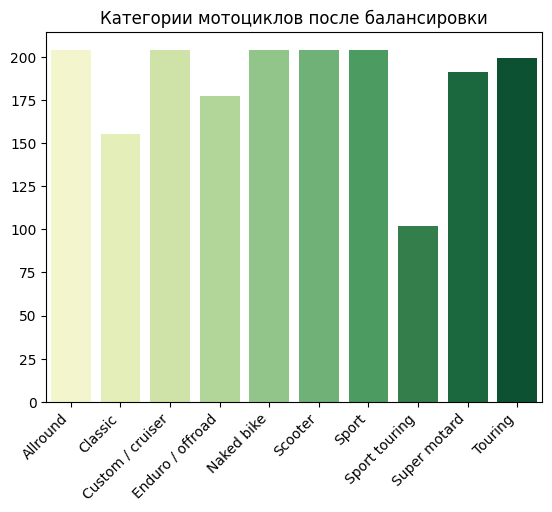

In [353]:
showSchedule(data_raw, 'Category', "после балансировки")
pass

# Описание

Можно взглянуть на мат. описание для каждого признака. Можно сделать несколько выводов. Например, средний год оказался именно 2014. Мотоциклы, что были произведены до этого года, лежат на свалках или аккуратно эксплуатируются стариками в душе. Мотоциклы, произведенные после, еще недостаточно изношены, чтобы стать дешевыми, поэтому продаж меньше. Конечно это не про все мотоциклы, но тенденция такова.

In [354]:
data_raw.describe()

,Year,Displacement (ccm),Power (hp),Torque (Nm),Bore (mm),Fuel capacity (lts),Dry weight (kg),Wheelbase (mm),Seat height (mm)
count,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000
mean,2014.886659,871.445174,83.140184,82.112364,82.527766,16.306914,205.463286,1486.125271,793.526573
std,5.956585,520.820792,51.486152,49.298456,17.397295,5.365321,70.789097,118.064390,167.506619
min,1968.000000,49.000000,1.500000,2.500000,37.000000,3.200000,52.000000,1050.000000,508.000000
25%,2012.000000,449.000000,41.725000,41.225000,72.000000,13.500000,167.000000,1420.000000,760.000000
50%,2016.000000,865.000000,86.000000,86.000000,83.000000,16.625000,193.000000,1490.000000,800.000000
75%,2019.000000,1198.400000,114.000000,118.500000,98.000000,20.000000,229.100000,1560.000000,830.000000
max,2022.000000,2458.000000,226.000000,221.000000,116.000000,33.000000,545.700000,2007.000000,7501.000000


Как мы видим из графика корреляции, многие из признаков сильно коррелируют с остальными. Год и высота сиденья, похоже, являются единственными показателями, не связанными ни с одним из остальных. С другой стороны, объем двигателя, крутящий момент и сухой вес тесно связаны с большинством других характеристик, а это означает, что они не добавляют много информации.

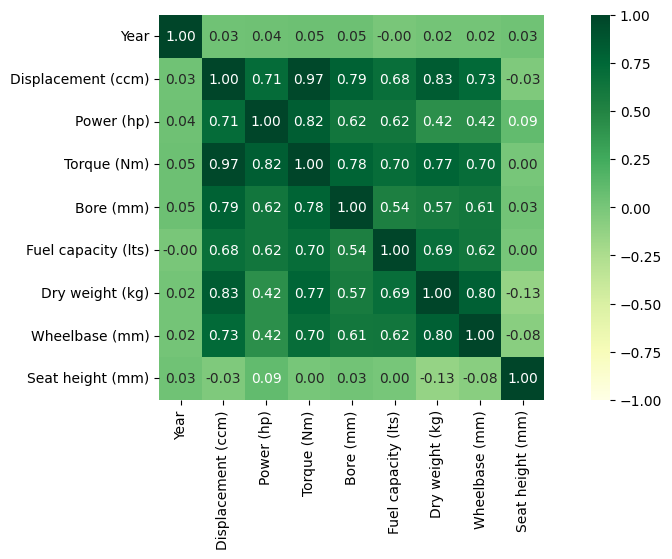

In [355]:
corr_mat = data_raw.corr()
plt.subplots(figsize=(12, 5))
sns.heatmap(corr_mat, square=True, annot=True, fmt='.2f', vmin=-1, vmax=1, cmap='YlGn')
pass

Посмотрим на корреляцию признака Category относительно других (количественных) признаков.

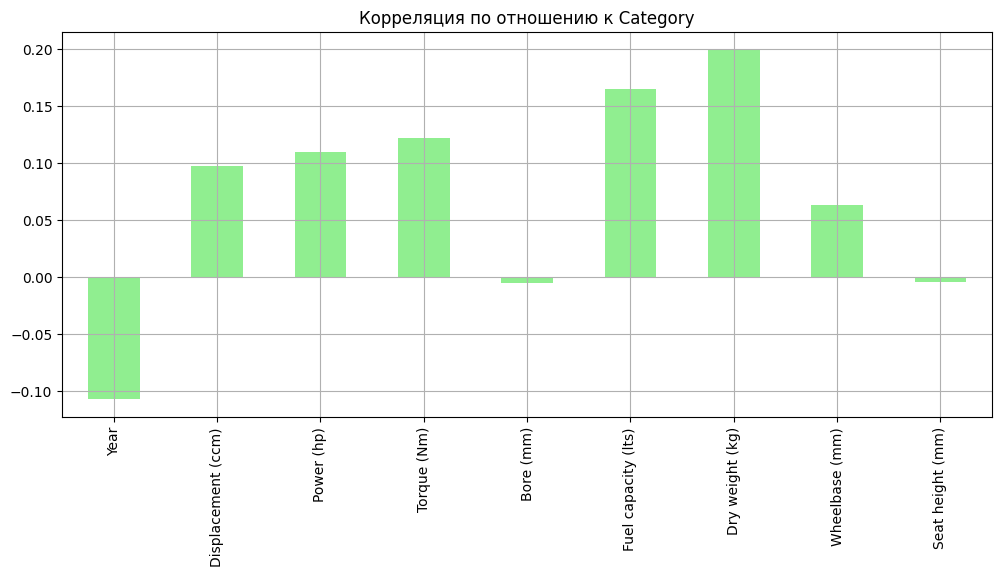

In [356]:
from sklearn.preprocessing import LabelEncoder

data_encoded = data_raw.copy()
le = LabelEncoder()
data_encoded['Category_encoded'] = le.fit_transform(data_encoded['Category'])

data_encoded.drop('Category_encoded', axis=1).corrwith(data_encoded['Category_encoded']).plot(kind='bar',
                                                                 grid=True,
                                                                 figsize=(12, 5),
                                                                 title="Корреляция по отношению к Category",
                                                                 color="lightgreen");
pass

Интересная картина, получается, что категория мотоцикла очень мало зависит от таких параметров как посадка и диаметр цилиндров в двигателе. Можно было бы убрать их из рассмотрения, но сначала посмотрим как отработает метод главных компонент (позже).

# Типизация


Заведем список имён столбцов относящихся к категориальному признаку:

In [357]:
categories = ["Category", "Engine cylinder", "Engine stroke", "Gearbox",
              "Transmission type", "Front brakes", "Rear brakes",
              "Front suspension", "Rear suspension", "Fuel system",
              "Fuel control", "Cooling system", "Front tire", "Rear tire", "Color options"]

Выведем типы категориальных признаков, видим, что все из них принадлежат типу 'object'.

In [358]:
showTypes(categories)

object -> 15


Приведем категориальные столбцы к типу 'category'.

In [359]:
data = data_raw.copy()

In [360]:
for category in categories:
  if data[category].dtype.name != 'category':
    data[category] = data[category].astype('category')

Посмотрим на оставшиеся признаки. Год является целочисленным признаком, остальные вещественными.

In [361]:
showTypes(data_raw)

int64 -> 1
object -> 16
float64 -> 8


Приведем количественные признаки к *numpy.Type* для определенности и фиксации размера.

In [362]:
type_int = ['Year']
type_float = list(set(data.columns) - set(categories) - set(type_int))
data_types = {k:np.float64 for k in type_float}
data_types['Year'] = np.int32

data = data.astype(data_types)

# type_float = ['Displacement (ccm)', 'Power (hp)', 'Torque (Nm)',
#               'Bore (mm)', 'Stroke (mm)', 'Fuel capacity (lts)',
#               'Dry weight (kg)', 'Wheelbase (mm)', 'Seat height (mm)']

# Обработка признаков

Большинство из наших категориальных столбцов имеют большое разнообразие вариантов. Это обусловлено различными комбинациями с использованием ключевых слов. Например для *Color options* -> *red, blue, yellow*.

In [363]:
categories = ["Category", "Engine cylinder", "Engine stroke", "Gearbox",
              "Transmission type", "Front brakes", "Rear brakes",
              "Front suspension", "Rear suspension", "Fuel system",
              "Fuel control", "Cooling system", "Front tire", "Rear tire", "Color options"]

Организуем список столбцов, с которыми нужно будет провести операцию get_dummies

In [364]:
dummies = []

## Engine cylinder

In [365]:
column = 'Engine cylinder'
showDiversity(data, column)

Разнообразие признака Engine cylinder: 11 вариантов


In [366]:
data['Engine cylinder'].value_counts()

V2                     680
Single cylinder        466
Twin                   247
In-line three          221
In-line four           123
Two cylinder boxer      35
V4                      35
In-line six             28
Diesel                   4
Six cylinder boxer       4
Four cylinder boxer      1
Name: Engine cylinder, dtype: int64

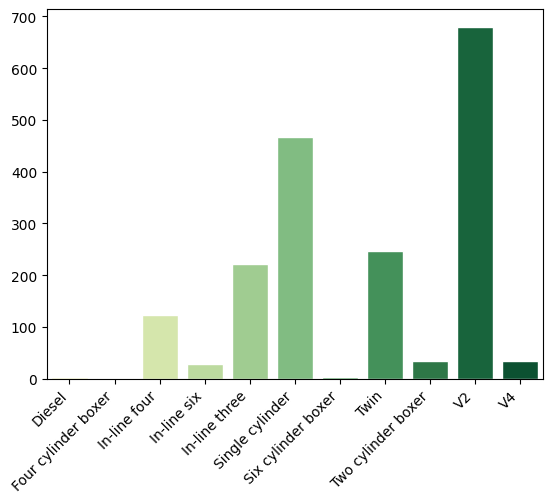

In [367]:
data[column].value_counts()
counts = data.groupby(column).count()
series_count = pd.Series(counts.iloc[:,0], index=counts.index)
bar_plot_series(series_count)
pass

Названия разные, но суть одна. Twin и V2 имеют по 2 цилинда. Переклассифицируем этот признак на буквально количество цилиндров в двигателе.

In [368]:
column = 'Engine cylinder amount'
data['Engine cylinder amount'] = data.loc[:,'Engine cylinder'].apply(n_cylinders)
data.drop(columns=['Engine cylinder'], axis=1, inplace=True)

In [369]:
data['Engine cylinder amount'].unique()

array([1, 2, 4, 3, 6])

Посмотрим, что получилось.

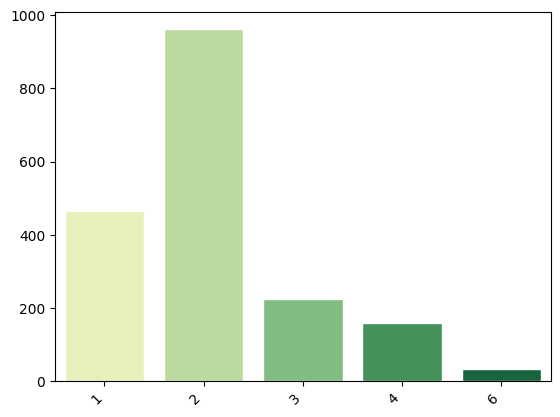

In [370]:
data[column].value_counts()
counts = data.groupby(column).count()
series_count = pd.Series(counts.iloc[:,0], index=counts.index)
bar_plot_series(series_count)
pass

## Engine stroke

In [371]:
column = 'Engine stroke'
data[column].value_counts()

 four-stroke    1811
 two-stroke       29
Diesel             4
Name: Engine stroke, dtype: int64

Получилось так, что *four-strike* занимает абсолютную часть вариантов. Бинаризируем столбец: 1 - 4-ех тактный двигатель, 0 - 2-ух тактный двигатель.

In [372]:
lb = LabelBinarizer()
data['Engine stroke'] = lb.fit_transform(data['Engine stroke'])
data[column].value_counts()

1    1811
0      33
Name: Engine stroke, dtype: int64

## Fuel system

In [373]:
column = 'Fuel system'
showDiversity(data, column)

Разнообразие признака Fuel system: 337 вариантов


Каждая запись представляет собой текстовое описание, где имеется уникальных именований. Описание включает числовые значения, обозначающие размеры деталей, названия торговых марок, распространённые союзы и т. д. Но есть две основных группы, инжекторная и карбюраторная системы подачи топлива. Разделим их по этому признаку и организуем два новых столбца Injection fuel system и Carburettor fuel system.

In [374]:
data['Carburettor fuel system'] = data[column].str.contains('Carburettor')
data['Injection fuel system'] = data[column].str.contains('Injection')

# Set the values of the new columns to 1 or 0
data['Carburettor fuel system'] = data['Carburettor fuel system'].astype('int8')
data['Injection fuel system'] = data['Injection fuel system'].astype('int8')

# Drop old column
data.drop(columns=[column], axis=1, inplace=True)

## Fuel control

In [375]:
column = 'Fuel control'
data[column].value_counts()

Double Overhead Cams/Twin Cam (DOHC)    981
Single Overhead Cams (SOHC)             381
Desmodromic valve control               262
Overhead Valves (OHV)                   105
Overhead Cams (OHC)                      99
Pushrods                                 12
Membrane                                  2
Membrane & power valve                    1
Port control                              1
Name: Fuel control, dtype: int64

Можно видеть несколько малочисленных групп в *Fuel control*. Выделим их в отдельную группу others.

In [376]:
counts = data[column].value_counts()
rare_values = counts[counts <= 10].index
data[column] = data[column].cat.add_categories('others')
data.loc[data[column].isin(rare_values), column] = 'others'

# Clear
categories = data[column].cat.categories
categories = [category for category in categories if data[column].value_counts()[category] != 0]
data[column] = data[column].cat.set_categories(categories)
data[column].value_counts()

Double Overhead Cams/Twin Cam (DOHC)    981
Single Overhead Cams (SOHC)             381
Desmodromic valve control               262
Overhead Valves (OHV)                   105
Overhead Cams (OHC)                      99
Pushrods                                 12
others                                    4
Name: Fuel control, dtype: int64

Образуем новые столбцы соответствующие этим вариантам.

In [377]:
dummies.append(column)

## Gearbox

Изначально не очень понятно к какой категории отнести автоматическую коробку передач. В смысле переключения передач вручную, это 0. А в смысле количества передач всё неоднозначно. Поэтому сделаем тот же трюк с dummies.

In [378]:
column = 'Gearbox'
data['Gearbox'].value_counts()

6-speed      1212
5-speed       402
Automatic     187
4-speed        40
3-speed         3
Name: Gearbox, dtype: int64

In [379]:
dummies.append(column)

## Cooling system

In [380]:
column = 'Cooling system'
data[column].value_counts()

Liquid       1074
Air           550
Oil & air     220
Name: Cooling system, dtype: int64

Не так много вариантов охлаждения придумали.

In [381]:
dummies.append(column)

## Transmission type

С трансмиссией та же самая история.

In [382]:
column = 'Transmission type'
data[column].value_counts()

Chain          1185
Belt            417
Shaft drive     242
Name: Transmission type, dtype: int64

In [383]:
dummies.append(column)

## Brakes

Тормоза существуют разных фирм и брендов. В их именах втречаются общие ключевые слова, характеризующие технические характеристики. Тормоза могут быть барабанные (drum) и дисковые. Дисковые тормоза могут быть как с одним так и с двумя дисками по разные стороны колеса (n_disks). Дисковые тормоза могут иметь разное количество поршней, отвечающий за сжатие суппортом диска (n_pistons). Тормозная система может обладать антиблокировачной системой (abs). Устройство тормозов чуть сложнее, но остановимся на этих ключевых аспектах.

In [384]:
column, key_word = 'Front brakes', 'front'
# dwdaw = data[column].unique()
# for i in range(len(dwdaw)):
#   print(dwdaw[i])

Создадим новый столбец характеристик, где каждая строка будет иметь числовое значение в зависимости от того, встречается ли ключевое слово в описании ее тормозной системы.

Это нужно сделать как для передних торомозов, так и для задних тормозов.

In [385]:
brakes_build(data, column, key_word)

В итоге получаем четыре новых столбца для передних тормозов: наличие abs системы, количество дисков (в случае барабанного тормоза 0), дисковый ли тормоз и число поршней.

In [386]:
data.iloc[:, -9:].head()

,Rear suspension,Color options,Engine cylinder amount,Carburettor fuel system,Injection fuel system,n_disks_front,has_front_disk,n_pistons_front,abs_front
170,Dual-damper unit swing arm,"Grey, Black, White",1,0,1,1,1,1.0,0.0
226,Dual-damper unit swing arm,"White, black, silver",1,0,1,1,1,1.0,0.0
227,Dual-damper unit swing arm,"White, black, silver",1,0,1,1,1,1.0,0.0
332,Ollé progressive system,White/red,1,1,0,1,1,1.0,0.0
350,Ollé progressive system,White/red/grey,1,1,0,1,1,2.0,0.0


Проделаем то же самое с задними тормозами, но с одним нюансом.

In [387]:
column, key_word = 'Rear brakes', 'rear'
brakes_build(data, column, key_word)

А теперь нюанс. Заменим столбцы с признаком наличия антиблокировочной системы для разных осей мотоцикла, на один столбец отвечающий на вопрос, есть ли вообще ABS на мотоцикле.

In [388]:
data['abs'] = data[['abs_front', 'abs_rear']].max(axis=1)
data.drop('abs_front', axis=1, inplace=True)
data.drop('abs_rear', axis=1, inplace=True)

Ну и осталось только удалить обработанные *Front brakes* и *Rear brakes*.

In [389]:
data.drop(columns=['Front brakes'], axis=1, inplace=True)
data.drop(columns=['Rear brakes'], axis=1, inplace=True)

## Tires

Информация о шинах предоставляется в трех возможных форматах: международном стандарте, цифровом и буквенно-цифровом. Регулярные выражения — идеальный инструмент для извлечения информации в данном случае.

Для шин можно извлечь следующие характеристики: ширину, высоту, индекс скорости, тип конструкции, диаметр и формат маркировки. Остальные значения Nan были заполнены в соответствии с разными критериями.

In [390]:
column, key_word = 'Front tire', 'front'
data = tyres_columns(data, column, key_word)

In [391]:
tires_build(data, key_word)

In [392]:
column, key_word = 'Rear tire', 'rear'
data = tyres_columns(data, column, key_word)

In [393]:
tires_build(data, key_word)

In [394]:
data.drop(columns = ['Front tire', 'Rear tire'], axis=1, inplace=True)
data.columns

Index(['Year', 'Category', 'Displacement (ccm)', 'Power (hp)', 'Torque (Nm)',
       'Engine stroke', 'Gearbox', 'Bore (mm)', 'Stroke (mm)',
       'Fuel capacity (lts)', 'Fuel control', 'Cooling system',
       'Transmission type', 'Dry weight (kg)', 'Wheelbase (mm)',
       'Seat height (mm)', 'Front suspension', 'Rear suspension',
       'Color options', 'Engine cylinder amount', 'Carburettor fuel system',
       'Injection fuel system', 'n_disks_front', 'has_front_disk',
       'n_pistons_front', 'n_disks_rear', 'has_rear_disk', 'n_pistons_rear',
       'abs', 'front_tire_width', 'front_tire_height', 'front_tire_diameter',
       'fronttire_speed', 'front_tire_construction_B',
       'front_tire_label_format_I', 'front_tire_label_format_N',
       'front_tire_label_format_A', 'rear_tire_width', 'rear_tire_height',
       'rear_tire_diameter', 'reartire_speed', 'rear_tire_construction_B',
       'rear_tire_label_format_I', 'rear_tire_label_format_N',
       'rear_tire_label_format_A

## Color options

Изначально идея классификации мотоциклов подразумевала использование технических характеристик двухколесных аппаратов. Поэтому цвет  стоит убрать из рассмотрения.

In [395]:
data.drop(columns=['Color options'], axis=1, inplace=True)

## Suspension

Вытащить и сформировать группы по подвеске будет мягко говоря тяжело, опустим этот момент. Удалим столбец.

In [396]:
data.drop(columns=['Front suspension'], axis=1, inplace=True)
data.drop(columns=['Rear suspension'], axis=1, inplace=True)

# Dummies


Добавим новые столбцы со значениями 0 или 1 в зависимости от вхождения в изначальный столбец. Который мы благополучно удалим.

In [397]:
data = pd.get_dummies(data, columns = dummies)

# Нормализация

Для лучшей работы многих алгоритмов машинного обучений необходима нормализация данных. Воспользуемся стандартным способом - линейным преобразованием, приводящем все значения к нулевому среднему и единичному среднеквадратичному отклонению.

In [398]:
numb_categories = list(data_types.keys())
data[numb_categories] = (data[numb_categories] - data[numb_categories].mean(axis = 0))/data[numb_categories].std(axis = 0)
data.describe()

,Year,Displacement (ccm),Power (hp),Torque (Nm),Engine stroke,Bore (mm),Stroke (mm),Fuel capacity (lts),Dry weight (kg),Wheelbase (mm),...,Gearbox_4-speed,Gearbox_5-speed,Gearbox_6-speed,Gearbox_Automatic,Cooling system_Air,Cooling system_Liquid,Cooling system_Oil & air,Transmission type_Belt,Transmission type_Chain,Transmission type_Shaft drive
count,1.844000e+03,1.844000e+03,1.844000e+03,1.844000e+03,1844.000000,1.844000e+03,1.844000e+03,1.844000e+03,1.844000e+03,1.844000e+03,...,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000
mean,1.530518e-14,1.233046e-16,1.078915e-16,-1.078915e-16,0.982104,-6.627622e-16,-3.082615e-17,-5.163380e-16,4.932184e-16,8.477191e-16,...,0.021692,0.218004,0.657267,0.101410,0.298265,0.582430,0.119306,0.226139,0.642625,0.131236
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.132609,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,0.145715,0.413002,0.474752,0.301953,0.457620,0.493292,0.324236,0.418444,0.479357,0.337750
min,-7.871399e+00,-1.579133e+00,-1.585673e+00,-1.614906e+00,0.000000,-2.616945e+00,-3.963038e+00,-2.442895e+00,-2.167894e+00,-3.693961e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-4.846165e-01,-8.111143e-01,-8.043946e-01,-8.293843e-01,1.000000,-6.051381e-01,-6.489590e-01,-5.231587e-01,-5.433504e-01,-5.600780e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.869092e-01,-1.237503e-02,5.554534e-02,7.885917e-02,1.000000,2.714412e-02,-1.395409e-01,5.928549e-02,-1.760622e-01,3.281878e-02,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,6.905535e-01,6.277684e-01,5.993809e-01,7.381090e-01,1.000000,8.893471e-01,2.725726e-01,6.883252e-01,3.339033e-01,6.257156e-01,...,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.194198e+00,3.046259e+00,2.774723e+00,2.817282e+00,1.000000,1.923991e+00,2.579263e+00,3.111293e+00,4.806343e+00,4.411785e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [399]:
data.iloc[:, :20].head()

,Year,Category,Displacement (ccm),Power (hp),Torque (Nm),Engine stroke,Bore (mm),Stroke (mm),Fuel capacity (lts),Dry weight (kg),Wheelbase (mm),Seat height (mm),Engine cylinder amount,Carburettor fuel system,Injection fuel system,n_disks_front,has_front_disk,n_pistons_front,n_disks_rear,has_rear_disk
170,0.690553,Scooter,-1.008879,-1.090394,-1.081421,1,-0.030336,-0.213950,-0.523159,0.099404,0.668065,-0.021053,1,0,1,1,1,1.0,1.0,0
226,-0.484616,Scooter,-1.072241,-1.171969,-1.057079,1,-0.260257,-0.196779,-0.523159,-0.402086,0.498666,0.128195,1,0,1,1,1,1.0,1.0,0
227,-0.148854,Scooter,-1.072241,-1.171969,-1.111847,1,-0.260257,-0.196779,-0.523159,-0.402086,0.498666,0.128195,1,0,1,1,1,1.0,1.0,0
332,0.019028,Super motard,-1.435129,-1.370081,-1.493198,1,-1.496081,-1.129758,-1.734643,-1.461571,-1.407073,0.277442,1,1,0,1,1,1.0,1.0,0
350,0.522672,Super motard,-1.435129,-1.370081,-1.493198,1,-1.496081,-1.129758,-1.734643,-1.433318,-1.407073,0.098345,1,1,0,1,1,2.0,1.0,0


In [400]:
le = LabelEncoder()
data['Category'] = le.fit_transform(data_raw['Category'])

# Формирование data и target

In [401]:
data_go = data.copy()
target = data_go['Category']
data_go.drop(columns=['Category'], axis=1, inplace=True)

In [402]:
X = data_go
y = target
from sklearn.model_selection import train_test_split

In [403]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 27)

N_train, _ = X_train.shape
N_test, _ = X_test.shape

N_train, N_test

(1659, 185)

# Методы машинного обучения

## Метод k-ближайших соседей (kNN)

In [404]:
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [405]:
from sklearn.metrics import accuracy_score

In [406]:
%%time
grid = GridSearchCV(KNeighborsClassifier(), param_grid = {
        'n_neighbors': [1,3,4,5,6],
        'algorithm': ['ball_tree', 'kd_tree'],
        'p':[1,2]
        })
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors

print('Ошибка на кросс-валидации: ', best_cv_err)
print('Оптимальное количество соседей: ', best_n_neighbors)
print('Оптимальный алгоритм: ', grid.best_estimator_.algorithm)
print('Оптимальная степень метрики: ', grid.best_estimator_.p)

Ошибка на кросс-валидации:  0.1898700542350671
Оптимальное количество соседей:  1
Оптимальный алгоритм:  ball_tree
Оптимальная степень метрики:  1
CPU times: user 6.22 s, sys: 18.7 ms, total: 6.24 s
Wall time: 6.35 s


In [407]:
%%time
knn = KNeighborsClassifier()

knn.set_params(n_neighbors = best_n_neighbors,
               algorithm = grid.best_estimator_.algorithm,
               p = grid.best_estimator_.p)
knn.fit(X_train, y_train)

err_train = np.mean(y_train != knn.predict(X_train))
err_test  = np.mean(y_test  != knn.predict(X_test))
acc_train = accuracy_score(y_true=y_train, y_pred=knn.predict(X_train))
acc_test = accuracy_score(y_true=y_test, y_pred=knn.predict(X_test))

print(f'''
Точность на обучающей выборке: {acc_train}
Точность на тестовой выборке: {acc_test}
Ошибка на обучающей выборке: {err_train}
Ошибка на тестовой выборке: {err_test}
''')


Точность на обучающей выборке: 0.9963833634719711
Точность на тестовой выборке: 0.8108108108108109
Ошибка на обучающей выборке: 0.003616636528028933
Ошибка на тестовой выборке: 0.1891891891891892

CPU times: user 547 ms, sys: 7.09 ms, total: 554 ms
Wall time: 555 ms


## SVC

In [408]:
from sklearn.svm import SVC

In [409]:
%%time
svc = SVC(gamma = 'auto')
svc.fit(X_train, y_train)

err_train = np.mean(y_train != svc.predict(X_train))
err_test  = np.mean(y_test  != svc.predict(X_test))
acc_train = accuracy_score(y_true=y_train, y_pred=svc.predict(X_train))
acc_test = accuracy_score(y_true=y_test, y_pred=svc.predict(X_test))

print(f'''
Ошибка на обучающей выборке: {err_train}
Ошибка на тестовой выборке: {err_test}
''')



Ошибка на обучающей выборке: 0.18806509945750452
Ошибка на тестовой выборке: 0.3081081081081081

CPU times: user 1.25 s, sys: 0 ns, total: 1.25 s
Wall time: 1.25 s


## Random forest

In [410]:
from sklearn import ensemble

In [411]:
%%time
rf = ensemble.RandomForestClassifier(n_estimators = 100)
rf.fit(X_train, y_train)

err_train = np.mean(y_train != rf.predict(X_train))
err_test  = np.mean(y_test  != rf.predict(X_test))
acc_train = accuracy_score(y_true=y_train, y_pred=rf.predict(X_train))
acc_test = accuracy_score(y_true=y_test, y_pred=rf.predict(X_test))

print(f'''
Ошибка на обучающей выборке: {err_train}
Ошибка на тестовой выборке: {err_test}
''')


Ошибка на обучающей выборке: 0.003616636528028933
Ошибка на тестовой выборке: 0.13513513513513514

CPU times: user 483 ms, sys: 0 ns, total: 483 ms
Wall time: 487 ms


## Extremely Randomized Trees

In [412]:
%%time
ert = ensemble.ExtraTreesClassifier(n_estimators = 100).fit(X_train, y_train)

err_train = np.mean(y_train != ert.predict(X_train))
err_test  = np.mean(y_test  != ert.predict(X_test))
acc_train = accuracy_score(y_true=y_train, y_pred=ert.predict(X_train))
acc_test = accuracy_score(y_true=y_test, y_pred=ert.predict(X_test))

print(f'''
Ошибка на обучающей выборке: {err_train}
Ошибка на тестовой выборке: {err_test}
''')


Ошибка на обучающей выборке: 0.003616636528028933
Ошибка на тестовой выборке: 0.15135135135135136

CPU times: user 431 ms, sys: 1.39 ms, total: 432 ms
Wall time: 433 ms


## AdaBoost

In [413]:
%%time
ada = ensemble.AdaBoostClassifier(n_estimators = 100)
ada.fit(X_train, y_train)

err_train = np.mean(y_train != ada.predict(X_train))
err_test  = np.mean(y_test  != ada.predict(X_test))
acc_train = accuracy_score(y_true=y_train, y_pred=ada.predict(X_train))
acc_test = accuracy_score(y_true=y_test, y_pred=ada.predict(X_test))

print(f'''
Ошибка на обучающей выборке: {err_train}
Ошибка на тестовой выборке: {err_test}
''')



Ошибка на обучающей выборке: 0.8679927667269439
Ошибка на тестовой выборке: 0.8972972972972973

CPU times: user 655 ms, sys: 3.99 ms, total: 659 ms
Wall time: 662 ms


## GBT

In [414]:
%%time
gbt = ensemble.GradientBoostingClassifier(n_estimators = 100)
gbt.fit(X_train, y_train)

err_train = np.mean(y_train != gbt.predict(X_train))
err_test  = np.mean(y_test  != gbt.predict(X_test))
acc_train = accuracy_score(y_true=y_train, y_pred=gbt.predict(X_train))
acc_test = accuracy_score(y_true=y_test, y_pred=gbt.predict(X_test))

print(f'''
Ошибка на обучающей выборке: {err_train}
Ошибка на тестовой выборке: {err_test}
''')


Ошибка на обучающей выборке: 0.018083182640144666
Ошибка на тестовой выборке: 0.12972972972972974

CPU times: user 7.45 s, sys: 2.52 ms, total: 7.46 s
Wall time: 7.56 s


## Выводы по работе алгоритмов

Адекватно себя показали методы основанные на принципе ансамбля деревьев. У остальных методов ошибка кратно больше, особенно AdaBoost. Думаю, остальные методы показали плохие результаты из-за того, что выборка мала, а количество объектов классификации велико.

**Extremely Randomized Trees** показал лучший результат ошибки в *~0.1513*.

**Random forest** недалеко ушел от собрата, ошибка в *~0.1351*.

Но лучшим оказался **GBT**: *~0.1297*.

**KNeighbors** показал не очень удовлетворительный результат. Оптимальное количество соседей равное одному наводит на подозрения несостоятельности получившегося датасета, при этом ошибка в *~0.1891*.

**SVC**: *~0.3405*.

**AdaBoost** показал наихудший результат в *~0.8972*. По идее этот алгоритм чувствителен к шуму и выбросам, но этого в датасете остаться не дОлжно. Значит дело в обыкновенном недостатке примеров для обучения.